In [1]:
import random

import gymnasium as gym
import numpy as np
import torch
import torch.optim as optim

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')

from src.rlmcmc.agent import Actor, QNetwork
from src.rlmcmc.env import RLMHEnvV33
from src.rlmcmc.utils import Args, MCMCAnimation, Toolbox
from src.rlmcmc.learning import LearningDDPGRandom

In [2]:
log_p = Toolbox.make_log_target_pdf(
    "test-banana-test-banana",
    "../../posteriordb/posterior_database"
)

In [3]:
# env setup
args = Args()
args.env_id = 'RLMHEnv-v3.3'
args.seed = 1234
args.log_target_pdf = log_p
args.total_timesteps = 100_000
# args.total_timesteps = 11
args.exploration_noise = 0.1
args.batch_size = 32
args.learning_starts = args.batch_size
args.learning_starts = 5_000
args.gamma = 0.1
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-5
args.policy_frequency = 2

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
predicted_envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
actor = torch.compile(actor)
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf1 = torch.compile(qf1)
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
qf1_target = torch.compile(qf1_target)
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor = torch.compile(target_actor)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False
)

In [4]:
learning = LearningDDPGRandom(
    env=envs,
    actor=actor,
    target_actor=target_actor,
    critic=qf1,
    target_critic=qf1_target,
    actor_optimizer=actor_optimizer,
    critic_optimizer=q_optimizer,
    replay_buffer=rb,
    total_timesteps=args.total_timesteps,
    learning_starts=args.learning_starts,
    batch_size=args.batch_size,
    exploration_noise=args.exploration_noise,
    gamma=args.gamma,
    policy_frequency=args.policy_frequency,
    tau=args.tau,
    seed=args.seed,
    device=device
)

In [5]:
training_func = learning.train(gradient_clipping=True)
# training_func.plot()
# training_func.dataframe()

  0%|          | 0/100000 [00:00<?, ?it/s]

[2024-01-23 00:43:55,080] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-23 00:43:55,080] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-23 00:43:55,081] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-23 00:43:55,082] [0/0] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split
[2024-01-23 00:43:59,344] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_3
[2024-01-23 00:43:59,345] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_2
[2024-01-23 00:43:59,346] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split_1
[2024-01-23 00:43:59,346] [0/1] torch._inductor.fx_passes.split_cat: [WARNING] example value absent for node: split
[2024-01-23 00:44:00,139] [1/0] torch._inductor.fx_passes.sp

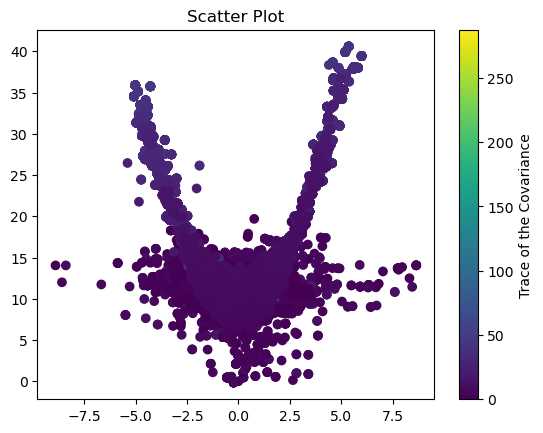

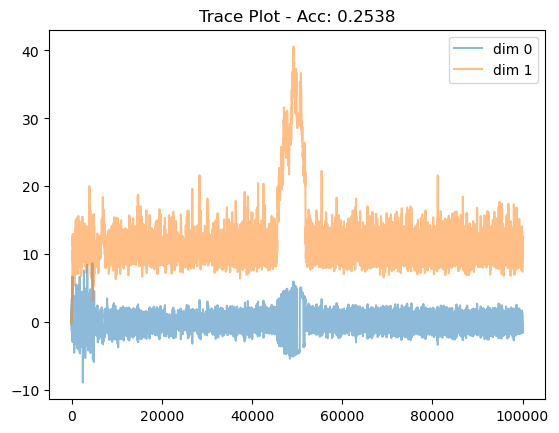

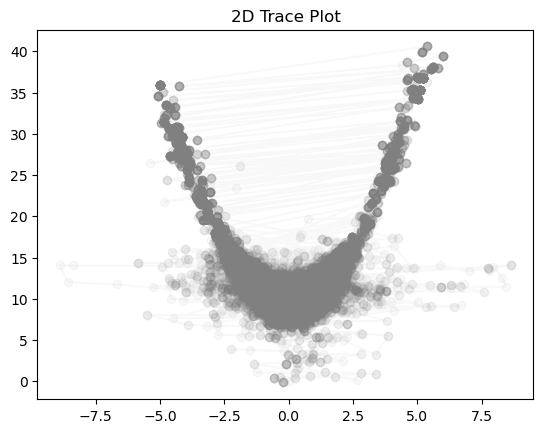

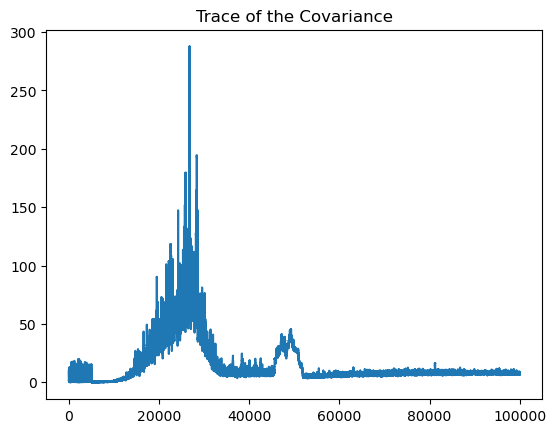

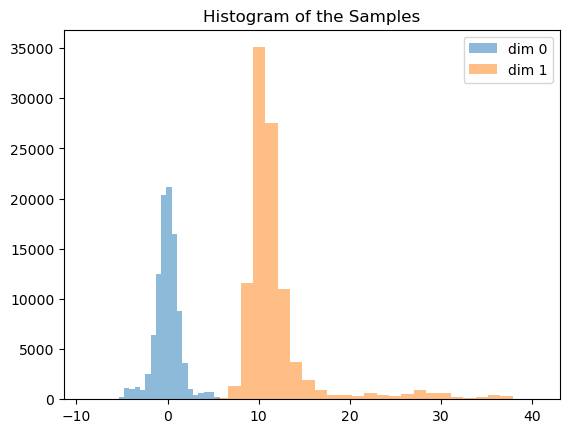

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

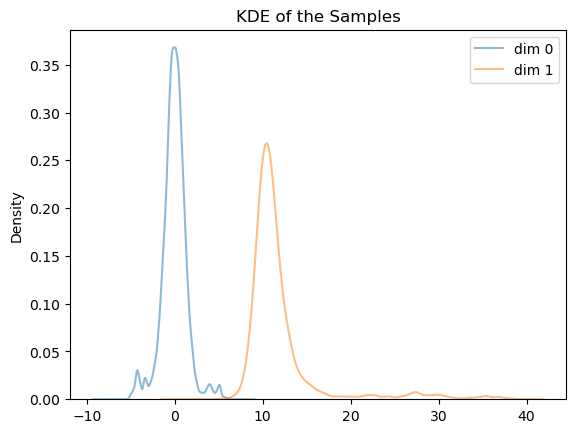

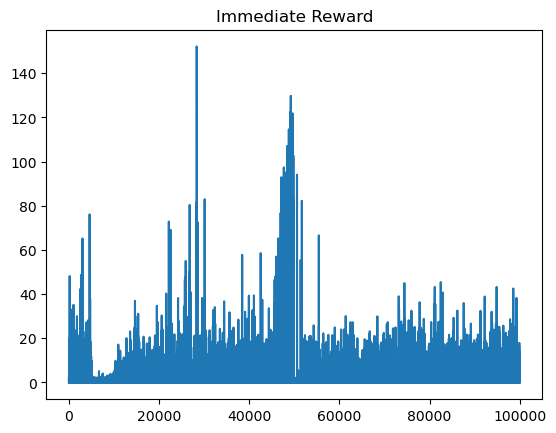

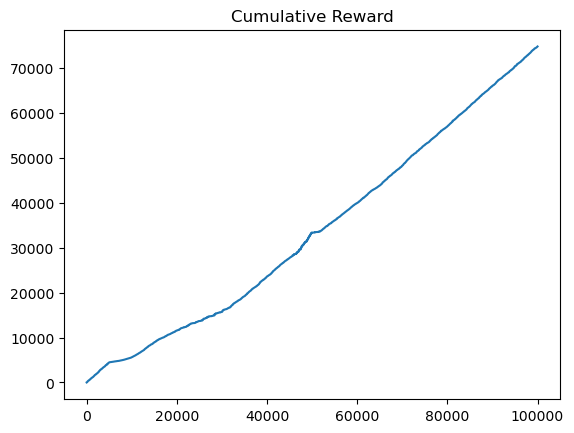

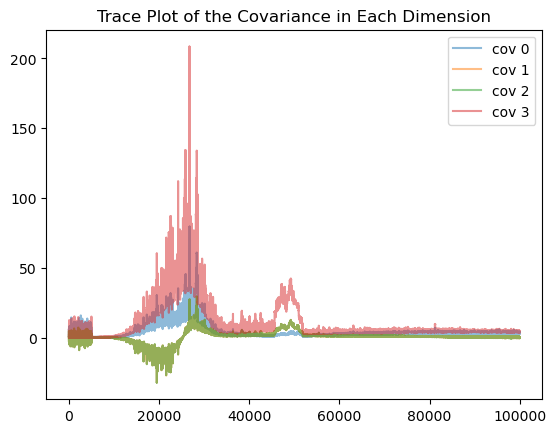

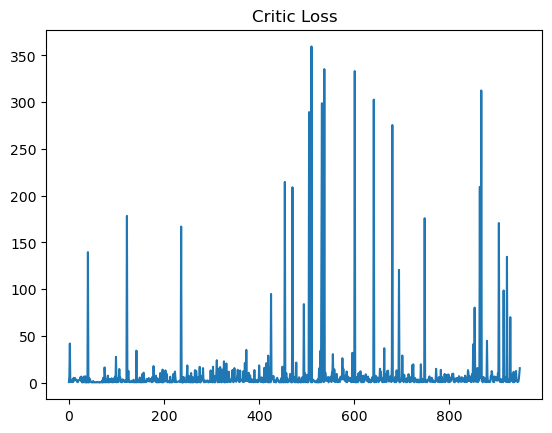

In [6]:
training_func.plot(critic_loss=True)

In [7]:
df_training = training_func.dataframe()

In [8]:
df_training.tail()

,x,y,proposed_x,proposed_y,cov1,cov2,cov3,cov4,proposed_cov1,proposed_cov2,proposed_cov3,proposed_cov4,rewards,log_alpha,accepted_status
99995,-1.503104,10.187886,-2.863636,10.841776,3.167731,-0.026119,-0.457995,4.145052,3.827039,-0.672347,-0.800788,4.491510,0.000000,-27.951446,0.0
99996,-1.503104,10.187886,0.560608,14.893897,3.189713,-0.261132,-0.394266,4.201877,4.245925,0.305274,0.342317,5.299190,0.000000,-6.523099,0.0
99997,-1.503104,10.187886,-0.003785,7.467936,3.231363,-0.300344,-0.375219,4.444085,2.898670,0.152145,-0.077906,3.830169,9.646087,-0.080280,1.0
99998,-0.003785,7.467936,-2.825726,5.477354,3.121884,-0.065420,0.134121,3.944164,2.961572,-0.784560,-0.694369,3.457814,0.000000,-79.576132,0.0
99999,-0.003785,7.467936,-0.370004,6.246568,2.727773,0.072703,0.052310,3.744265,2.563674,-0.114678,-0.085458,3.512780,0.000000,-4.389386,0.0


In [9]:
# df_training[20000:25000]

  0%|          | 0/5000 [00:00<?, ?it/s]

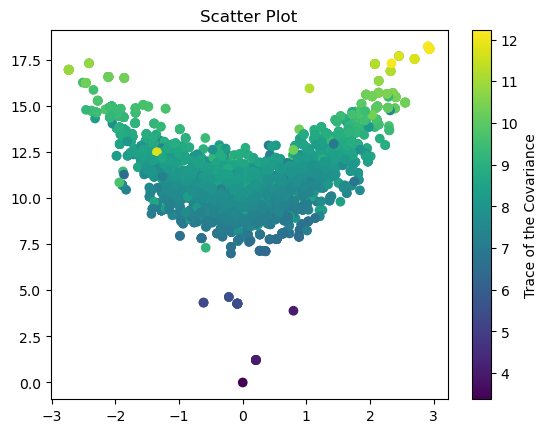

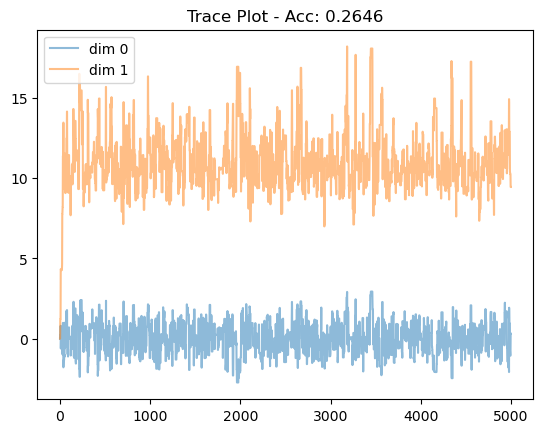

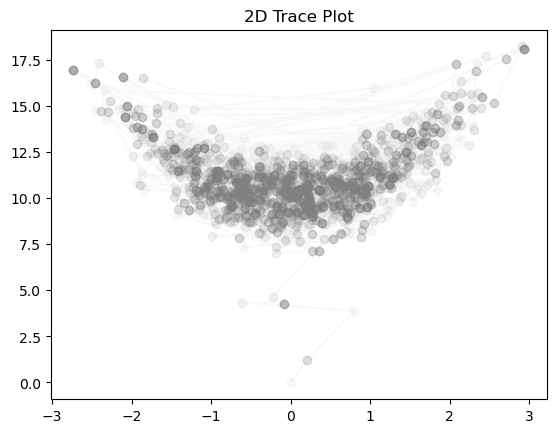

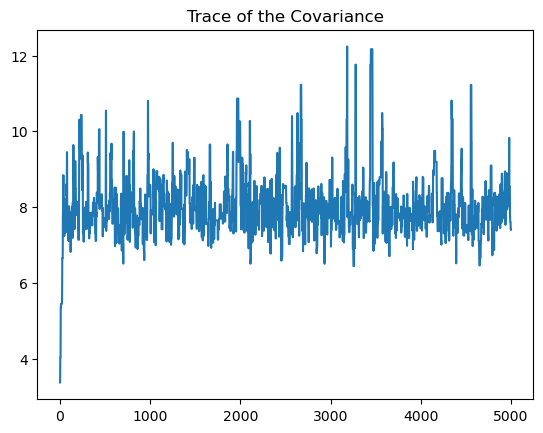

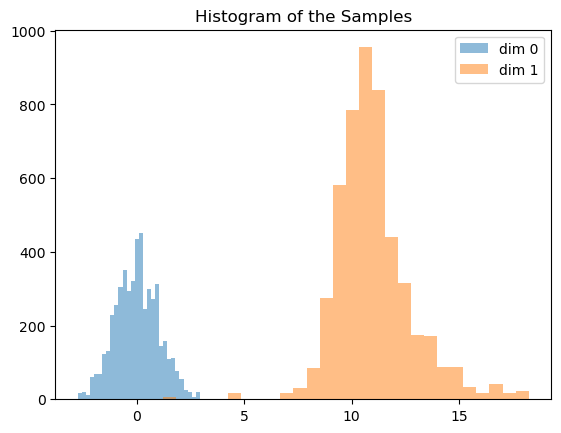

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

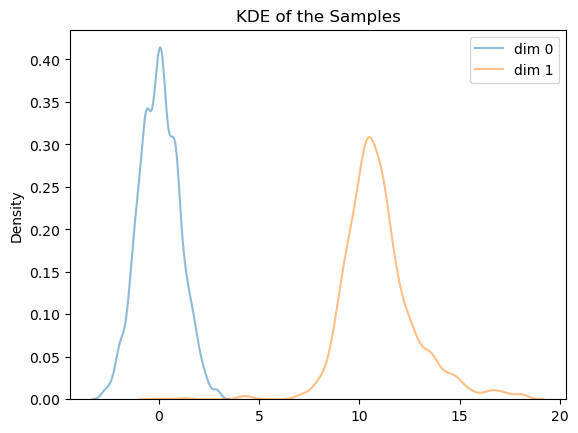

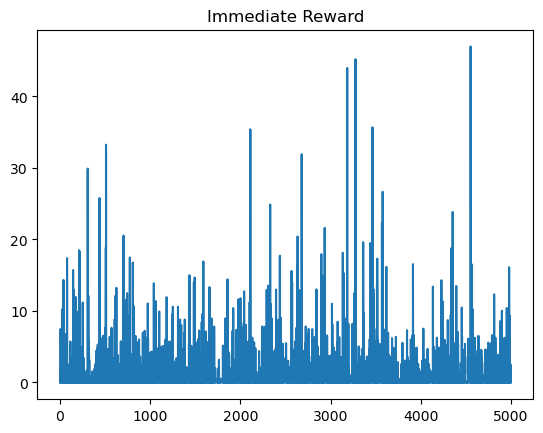

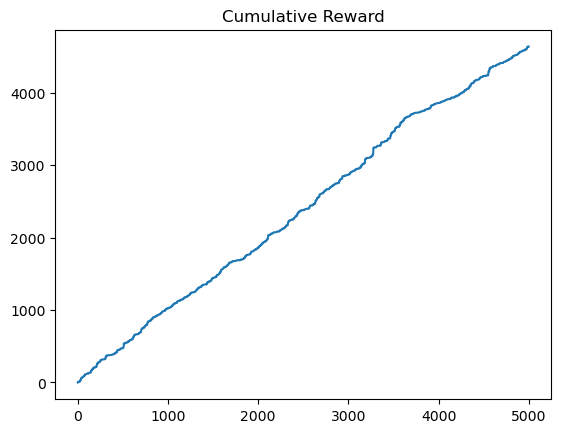

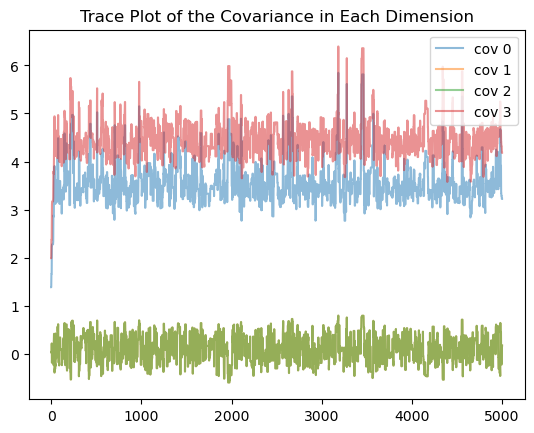

In [28]:
predict_func = learning.predict(predicted_envs, 5_000)
predict_func.plot()

In [11]:
# predict_func.dataframe().to_csv("save/data/predict.csv", index=False)

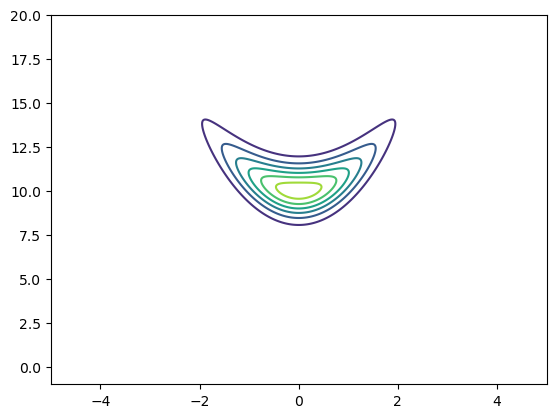

In [29]:
mcmc_animation = MCMCAnimation(
    log_target_pdf=log_p,
    dataframe=predict_func.dataframe(),
    xlim=(-5, 5),
    ylim=(-1, 20)
    )

In [30]:
anim_file_path = "./save/data/banana_predict_test.mp4"
mcmc_animation.make().save(anim_file_path, writer='ffmpeg')

In [37]:
learning.save("save/model")

In [15]:
# predict_func.dataframe().head()

In [32]:
learning.actor(torch.tensor([[0.0, 0.0, 0.0, 0.0]], dtype=torch.double))

tensor([[1.3848, 0.0374, 0.0374, 1.9892, 1.3848, 0.0374, 0.0374, 1.9892]],
       dtype=torch.float64, grad_fn=<CompiledFunctionBackward>)

In [33]:
learning.actor(torch.tensor([[10.0, 0.0, 0.0, 0.0]], dtype=torch.double))

tensor([[3.2805, 0.5298, 0.5298, 3.6502, 3.2805, 0.5298, 0.5298, 3.6502]],
       dtype=torch.float64, grad_fn=<CompiledFunctionBackward>)

In [34]:
learning.actor(torch.tensor([[10.0, 0.0, 0.0, 0.0]], dtype=torch.double))

tensor([[73.6345, 10.1811, 10.1811, 76.3993, 73.6345, 10.1811, 10.1811, 76.3993]],
       dtype=torch.float64, grad_fn=<CompiledFunctionBackward>)

In [35]:
learning.actor(torch.tensor([[0.0, 10.0, 0.0, 0.0]], dtype=torch.double))

tensor([[3.3868, 0.0916, 0.0916, 4.4476, 3.3868, 0.0916, 0.0916, 4.4476]],
       dtype=torch.float64, grad_fn=<CompiledFunctionBackward>)

In [36]:
learning.actor(torch.tensor([[10.0, 20.0, 0.0, 0.0]], dtype=torch.double))

tensor([[7.4050, 1.1875, 1.1875, 7.9668, 7.4050, 1.1875, 1.1875, 7.9668]],
       dtype=torch.float64, grad_fn=<CompiledFunctionBackward>)